# Jogo Organelas - Conhecendo as organelas de uma célula
    This file is part of program Activ Spyder
    Copyright © 2022 Carlo Oliveira carlo@nce.ufrj.br,
    Labase <http://labase.selfip.org/>; GPL <http://is.gd/3Udt>.
    SPDX-License-Identifier: (GPLv3-or-later AND LGPL-2.0-only) WITH bison-exception

## Análise dos dados da API de coleta -
    Obtem versões dos relatórios dos games.
[!NOTE]
codeauthor:: Carlo Oliveira [carlo at ufrj](mailto:carlo@ufrj.br)

## Changelog

<!--![version added](https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/solid/circle-plus.svg)  22.06-->
<img src="https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/solid/circle-plus.svg" width=16/>  22.06

* Criação do raspador de página.
* Análise preliminar dos dados.
* Recorte de múltiplos usuários (falhando).

## Obtendo os dados do Github
O arquivo de pontuação é guardado no repositório [lorinda lisa score](https://raw.githubusercontent.com/kwarwp/lorinda/master/lisa/__score__.py). Este arquivo foi gerado pela coleta de dados feita pelo jogo das organelas, registrando as principais interações do jogador com s personagens do jogo.

In [118]:
import urllib.request
from json import loads
# import csv
import pandas as pd
lisa_score_url = "https://raw.githubusercontent.com/kwarwp/lorinda/master/lisa/__score__.py"
f00 = "{'doc_id': 'a42ac145', 'carta': 'parte_1', 'casa': 'Fase0', 'move': 'local', 'ponto': 0, 'valor': 'local', '_level': 1, 'tempo': ".replace("'", '"')
try:
    with urllib.request.urlopen(lisa_score_url) as f, open("lisa_score.csv", "w") as score_csv:
        lisa_score = f.read().decode('utf-8').replace("'", '"').replace("Fase","Fase0").replace("Fase011","Fase11")
        lisa_score = f"[{lisa_score[:-2]}]"
        # print(lisa_score[-300:])
        lisa_score = loads(lisa_score)
        # print(lisa_score[0], lisa_score[-1])
        headings = ['doc_id', 'carta', 'casa', 'move', 'ponto', 'valor', '_level', 'tempo']
        datan = {key: [] for key in headings}
        [datan[key].append(val) for line in lisa_score for key, val in line.items() if key in headings]
        # w = csv.DictWriter(score_csv, datan.keys())
        # w.writeheader()
        # w.writerow(datan)
        df = pd.DataFrame(datan)
        df.sort_values(by=['doc_id','tempo',], inplace=True)
        # df["movetime"] = df.groupby('doc_id')['tempo'].apply(lambda x: x - x.shift(1))
        df["movetime"] = df.groupby('doc_id').tempo.diff()
        df = df[df.groupby(['doc_id'])['movetime'].transform('sum') > 100000]

        df.tempo = pd.to_datetime(df.tempo)
        df.info()
except urllib.error.URLError as e:
    print(e.reason)
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3058 entries, 2119 to 3065
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   doc_id    3058 non-null   object        
 1   carta     3058 non-null   object        
 2   casa      3058 non-null   object        
 3   move      3058 non-null   object        
 4   ponto     3058 non-null   int64         
 5   valor     3058 non-null   object        
 6   _level    3058 non-null   int64         
 7   tempo     3058 non-null   datetime64[ns]
 8   movetime  3024 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 238.9+ KB


,doc_id,carta,casa,move,ponto,valor,_level,tempo,movetime
2119,04371ac6,parte_0,Fase01,local,0,local,1,1970-01-01 00:27:34.697539054,NaN
2120,04371ac6,parte_e,Fase01,local,0,local,1,1970-01-01 00:27:34.697539278,224.0
2121,04371ac6,parte_0,Fase00,local,0,local,1,1970-01-01 00:27:34.697539505,227.0
2122,04371ac6,parte_1,Fase00,local,0,local,1,1970-01-01 00:27:34.697539643,138.0
2123,04371ac6,parte_1,Fase00,local,0,local,1,1970-01-01 00:27:34.697539776,133.0
...,...,...,...,...,...,...,...,...,...
3059,f74fcfaf,parte_3,Fase09,local,0,local,1,1970-01-01 00:27:34.701279729,3702.0
3060,f74fcfaf,parte_4,Fase07,local,0,local,1,1970-01-01 00:27:34.701309805,30076.0
3061,f74fcfaf,parte_5,Fase07,local,0,local,1,1970-01-01 00:27:34.701313388,3583.0
3062,f74fcfaf,parte_0,Fase11,local,0,local,1,1970-01-01 00:27:34.701320681,7293.0


array([[<AxesSubplot:title={'center':'ponto'}>,
        <AxesSubplot:title={'center':'_level'}>],
       [<AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'movetime'}>]], dtype=object)

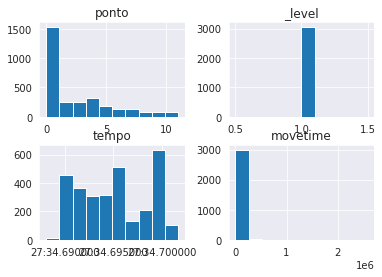

In [119]:
df.hist()

## Recorte dos jogadores usando o mesmo computador
O arquivo de dados registra uma única identificação para todos os jogadores que usaram o mesmo computador. Este código separa estes jogadores baseado em registro de início de jogo.

In [120]:
# cut = df.index[(df['casa'] == "Fase0") & (df["carta"] == "parte_0")].tolist()
# cut = df.index[df.loc[(df['casa'] == "Fase0") & (df["carta"] == "parte_0")]].tolist()
# [df.iloc[c] for c in cut]
ddict = df.to_dict('records')
ALPHA = [a+b for a in "bcdfghjklmnpqrstvxz" for b in "01234"]
#cuts = [ind for ind, dc in enumerate(ddict) if (dc['casa'] == "Fase0") and (dc["carta"] == "parte_0")]
cuts = [ind for ind, dc in enumerate(ddict) if (dc['casa'] == "Fase01") and (dc["carta"] == "parte_0")]
cuts = zip(cuts, cuts[1:]+[len(df)])
cuts = list(cuts)
# print(len(cuts), cuts)
dcut = [{k: v if k != "doc_id" else ALPHA[ind] for k,v in dc.items()}
        for ind, (st,ed) in enumerate(cuts) for dc in ddict[st:ed]
        if ((ed-st)>10) and ind <200 and ALPHA[ind] not in "g1 k3 s1"]
dcuts = [[{k: v if k != "doc_id" else ALPHA[ind] for k, v in dc.items()} for dc in ddict[st:ed]]
         for ind, (st,ed) in enumerate(cuts) if ((ed-st)>10)]# and ind not in (6, 9, 23, 17, 19) and ind <20]
# [print(d[0]) for d in dcuts]
#[print(d) for d in dcuts[9]]
df = pd.DataFrame(dcut)
df.loc[(df["casa"] == "Fase01")&(df["carta"] == "parte_0"), "movetime"] = 111.1
# df.info()
'''

cut.sort()
ranges = zip([0]+cut, cut+[len(df)])
# [print( r) for r in ranges]
# sorted(cut)
dfs = [df.iloc[start:end, :] for start, end in ranges]
print([len(d) for d in dfs])
dfs[1]'''
# dfs
# len(dfs)
# dfs[-1]
# [print(len(d)) for d in dfs]
# [d for d in dfs if len(d)>400][0]
df


,doc_id,carta,casa,move,ponto,valor,_level,tempo,movetime
0,b1,parte_0,Fase01,local,0,local,1,1970-01-01 00:27:34.698747018,111.1
1,b1,parte_a,Fase01,local,0,local,1,1970-01-01 00:27:34.698755153,8135.0
2,b1,parte_c,Fase01,local,0,local,1,1970-01-01 00:27:34.698763387,8234.0
3,b1,parte_b,Fase01,local,0,local,1,1970-01-01 00:27:34.698766251,2864.0
4,b1,parte_d,Fase01,local,0,local,1,1970-01-01 00:27:34.698779892,13641.0
...,...,...,...,...,...,...,...,...,...
2272,v2,parte_3,Fase09,local,0,local,1,1970-01-01 00:27:34.701279729,3702.0
2273,v2,parte_4,Fase07,local,0,local,1,1970-01-01 00:27:34.701309805,30076.0
2274,v2,parte_5,Fase07,local,0,local,1,1970-01-01 00:27:34.701313388,3583.0
2275,v2,parte_0,Fase11,local,0,local,1,1970-01-01 00:27:34.701320681,7293.0


## Contagem de jogadas em cada fase
Mostra a contagem média de jogadas em cada fase e a variação entre elas

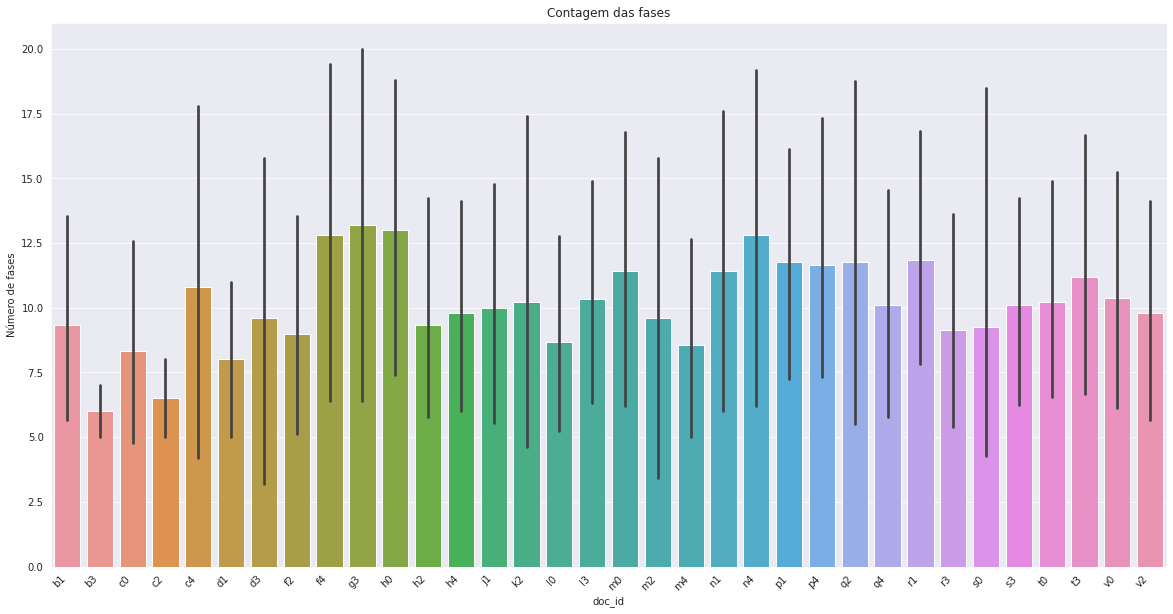

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
# ds = df.loc[(df['casa'] == "Fase0") & (df["carta"] == "parte_0")]
ds = df.loc[((df['casa'] == "Fase02")|(df['casa'] == "Fase01")) & (df["carta"] == "parte_0")]
# ds = df.groupby(['doc_id', 'casa', "carta"])['_level'].sum().reset_index()
ds = df.groupby(['doc_id', 'casa'])['_level'].sum().reset_index()
# ds = df[df.groupby(['doc_id'])['casa' == ]]
chart = sns.barplot(x="doc_id", y="_level", data=ds)
chart.set(
    title='Contagem das fases', ylabel='Número de fases')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# chart.set(ylim=(0, 20000))
plt.gcf().set_size_inches(20, 10)
# ds


## Distribuição da contagem de jogadas por fase

Mostra quantas jogadas cada jogador fez em cada fase. As fases 8 e 10 não coletaram dados neste jogo. Podemos observar que muitos participantes não jogaram todas as fases.

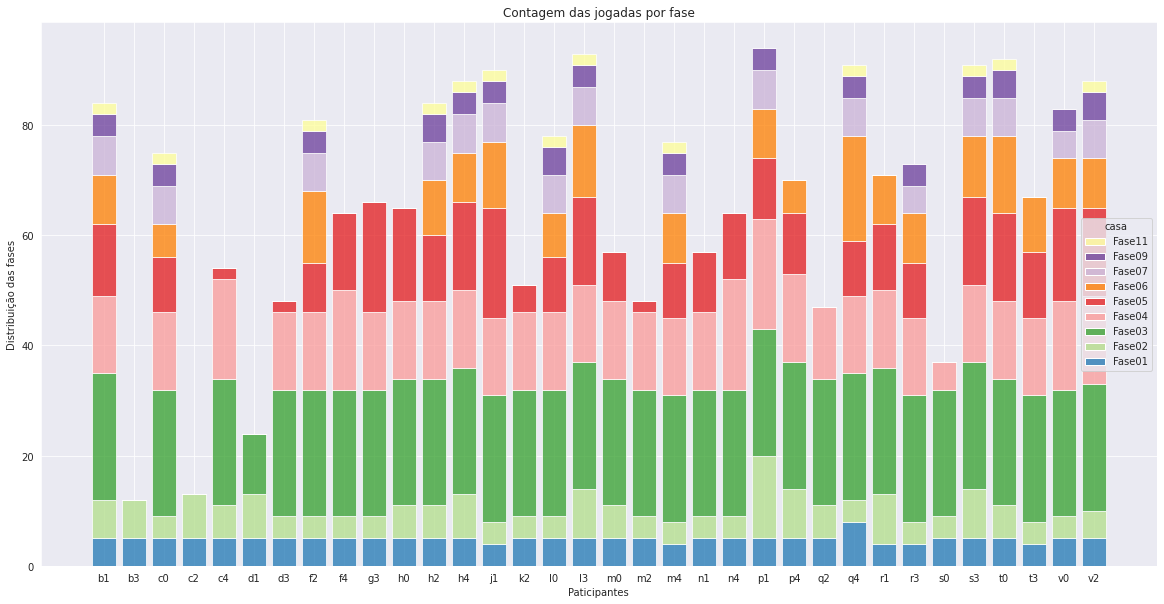

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
# ds = df.groupby(['doc_id', 'casa', "carta"])['_level'].sum().reset_index()
ds = df.groupby(['doc_id', 'casa'])['_level'].sum().reset_index()
hue_order = [f"Fase{ind:02}" for ind in range(11, 0,-1) if ind not in (8, 10)]
color = "red orange yellow lime green  cyan teal blue indigo magenta purple".split()
da = ds.pivot(['doc_id'], 'casa', '_level') \
      .rename_axis(columns=None).reset_index()
ax = sns.histplot(data = ds, x='doc_id', hue='casa', weights='_level', hue_order=hue_order,
             multiple='stack', palette='Paired_r', shrink=0.8).set(
    title='Contagem das jogadas por fase', ylabel='Distribuição das fases', xlabel="Paticipantes")

plt.gcf().set_size_inches(20, 10)
# plt.gca().invert_yaxis()
# ds


## Distribuição dos tempos das jogadas
No jogo, muitas das jogadas envolvem a leitura de um pequeno texto. O gráfico pode indicar, portanto, melhores leitores, quando a média dos tempos é baixa.

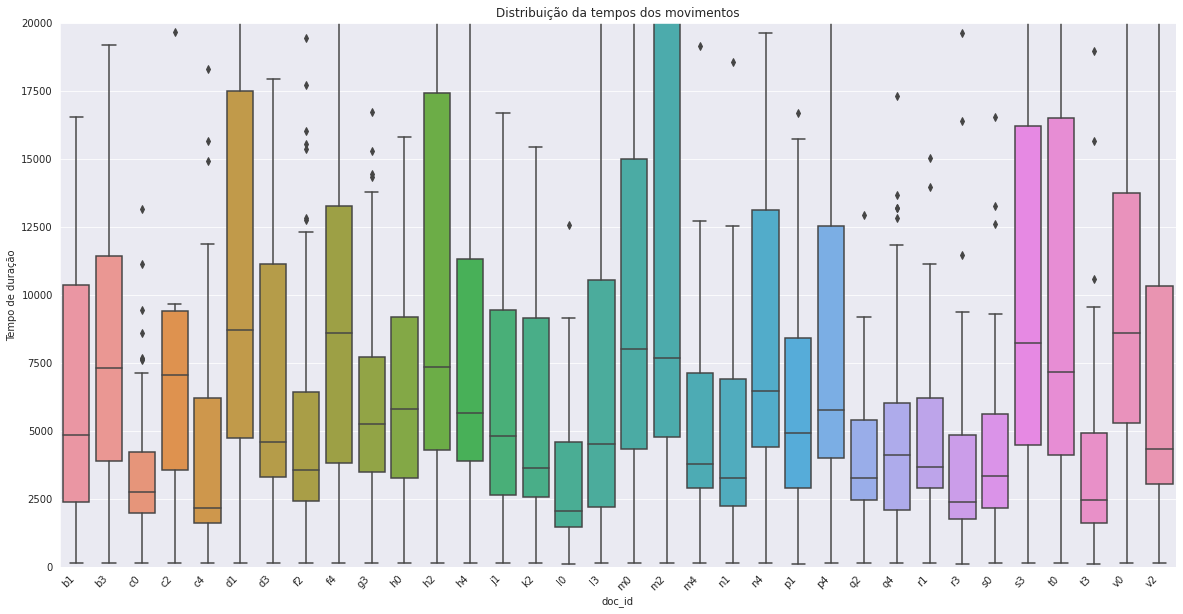

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
chart = sns.boxplot(x="doc_id", y="movetime", data=df)
chart.set(
    title='Distribuição da tempos dos movimentos', ylabel='Tempo de duração')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(ylim=(0, 20000))
plt.gcf().set_size_inches(20, 10)

## Distribuição dos tempos de jogada por fase
As fase do jogo tem um nível desigual de complexidade em suas fases. O diagrama abaixo mostra esta variação.

,doc_id,casa,movetime
0,b1,Fase01,32985.1
1,b1,Fase02,42463.0
2,b1,Fase03,95681.0
3,b1,Fase04,301524.0
4,b1,Fase05,275749.0
...,...,...,...
219,v2,Fase05,1143180.0
220,v2,Fase06,174561.0
221,v2,Fase07,126711.0
222,v2,Fase09,62262.0


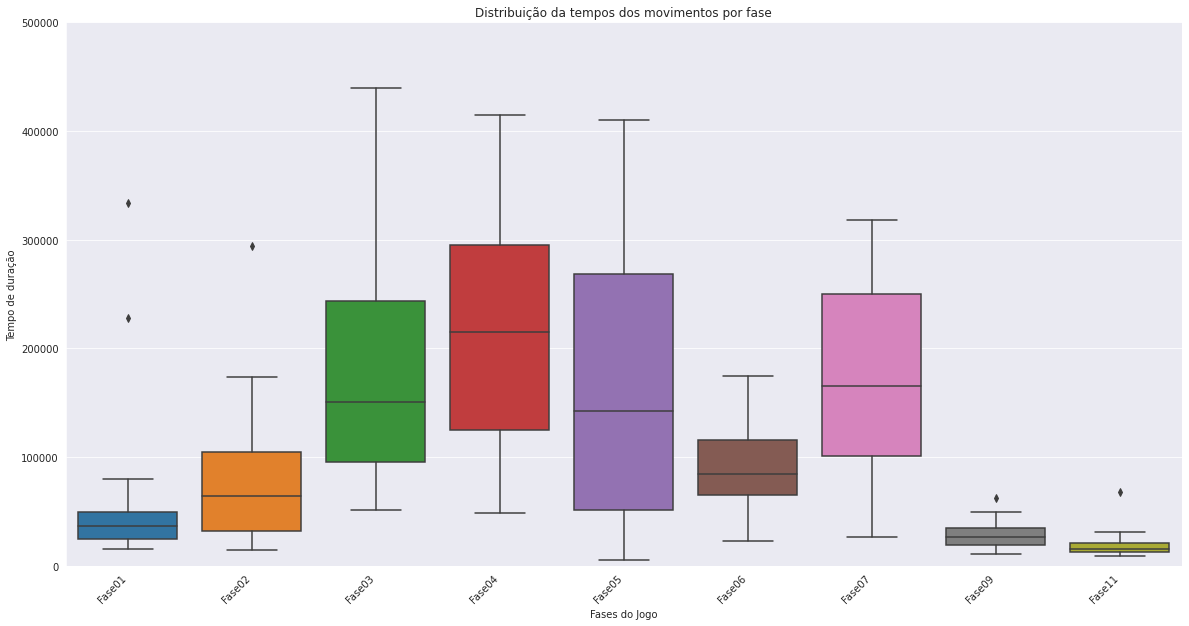

In [124]:
ds = df.groupby(['doc_id', 'casa'])['movetime'].sum().reset_index()
import seaborn as sns
import matplotlib.pyplot as plt
chart = sns.boxplot(x="casa", y="movetime", data=ds)
chart.set(
    title='Distribuição da tempos dos movimentos por fase', ylabel='Tempo de duração', xlabel='Fases do Jogo')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(ylim=(0, 500000))
plt.gcf().set_size_inches(20, 10)
ds

## Variação no tempo de resposta
A variação no tempo de resposta está ligado à evolução microgenética do processo de aprendizagem. A diminuição do tempo de resposta pode indicar uma melhor taxa de acomodação dos novos conhecimentos.

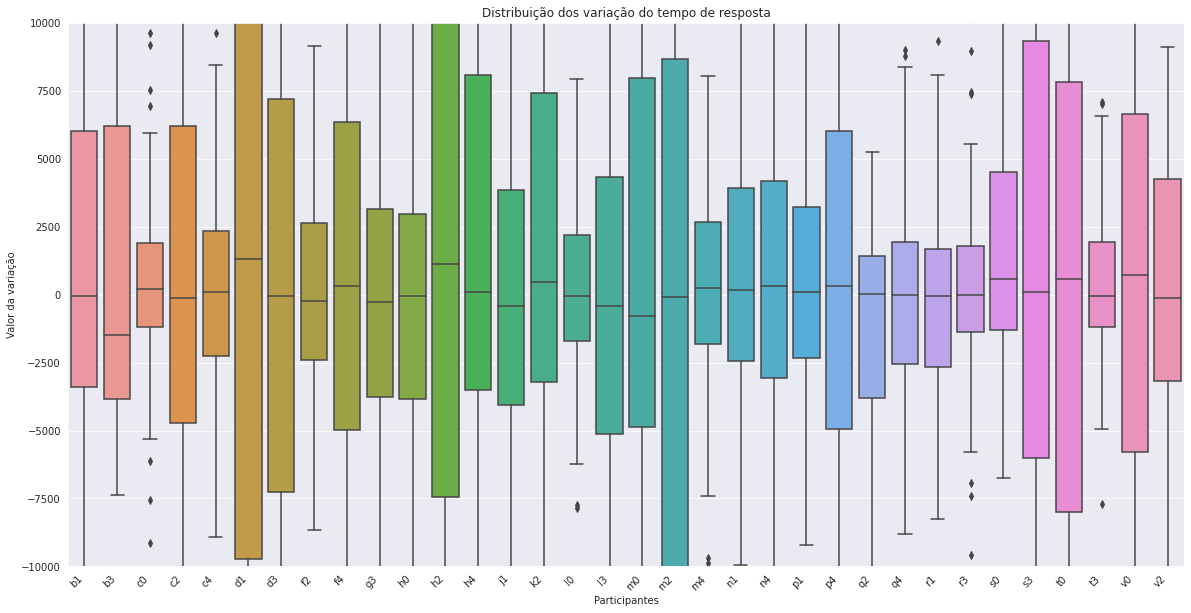

In [125]:
df["movedelta"] = df.groupby('doc_id')['movetime'].apply(lambda x: x - x.shift(1))
chart = sns.boxplot(x="doc_id", y="movedelta", data=df)
chart.set(
    title='Distribuição dos variação do tempo de resposta', ylabel='Valor da variação', xlabel='Participantes')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(ylim=(-10000, 10000))
plt.gcf().set_size_inches(20, 10)



## Aceleração do tempo de resposta
A aceleração do tempo de resposta é um indício do processo metacognitivo em ação. Mudanças na variação do tempod de resposta são indícios que saltos cognitivos estão em andamento

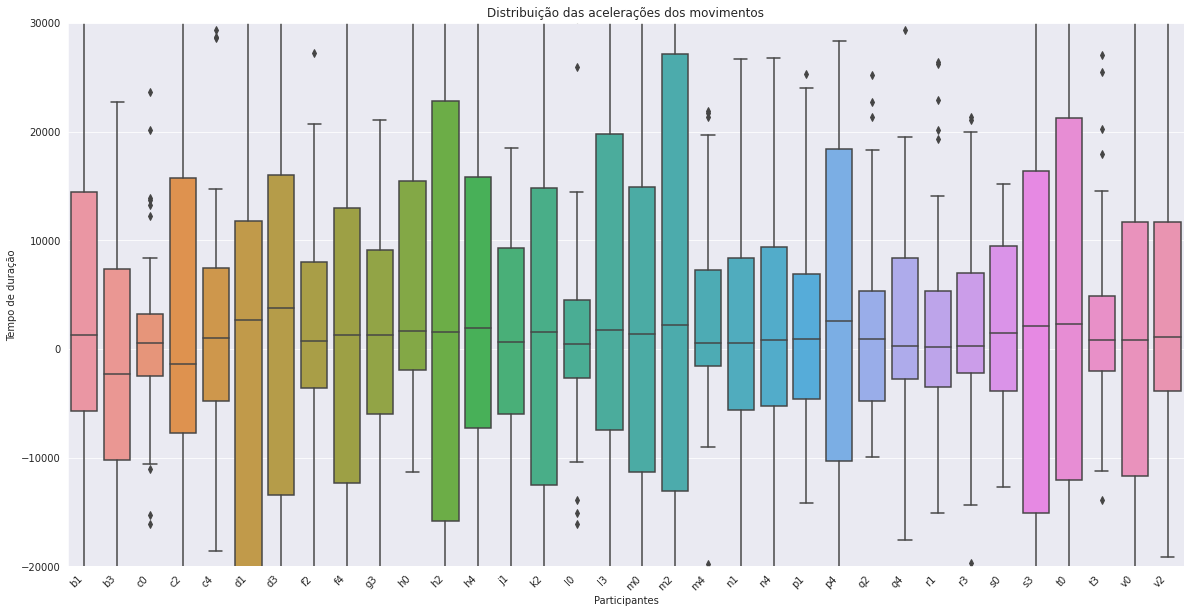

In [126]:
df["movejump"] = df.groupby('doc_id')['movedelta'].apply(lambda x: x - x.shift(1))
chart = sns.boxplot(x="doc_id", y="movejump", data=df)
chart.set(
    title='Distribuição das acelerações dos movimentos', ylabel='Tempo de duração', xlabel='Participantes')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# chart.set(ylim=(-30000, 30000))
chart.set(ylim=(-20000, 30000))
plt.gcf().set_size_inches(20, 10)

## Médias dos tempos por fase
Observando as médias dos tempos das jogadas, considerando as diversas fases do jogo.

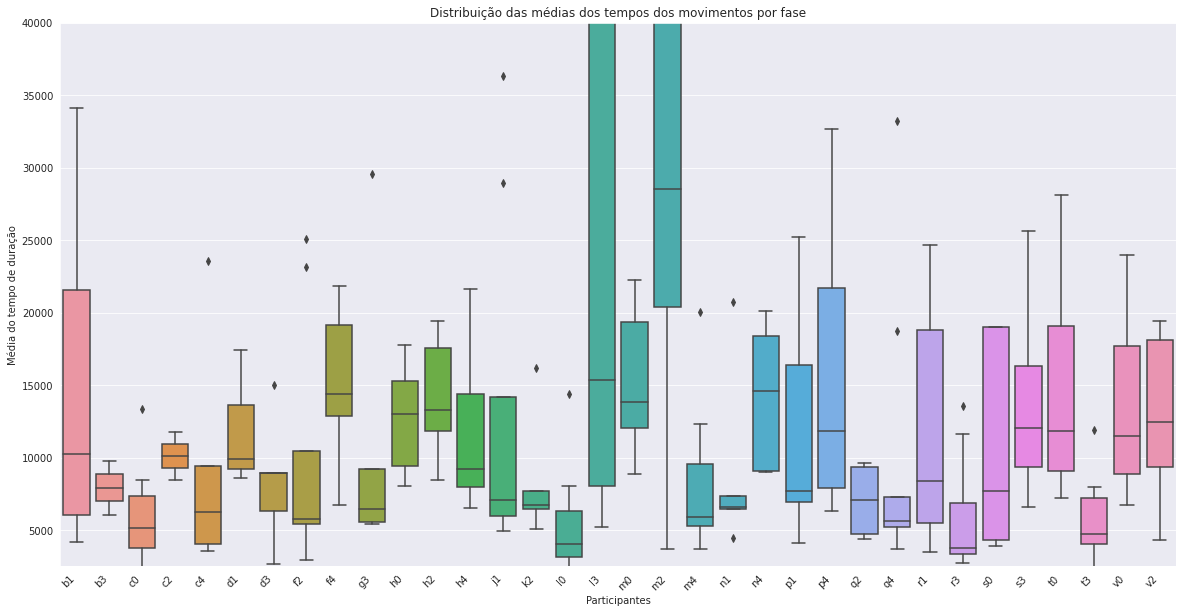

In [127]:
ds = df.groupby(['doc_id', 'casa'])['movetime'].mean().reset_index()
import seaborn as sns
import matplotlib.pyplot as plt
chart = sns.boxplot(x="doc_id", y="movetime", data=ds)
chart.set(
    title='Distribuição das médias dos tempos dos movimentos por fase', ylabel='Média do tempo de duração', xlabel='Participantes')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(ylim=(2500, 40000))
plt.gcf().set_size_inches(20, 10)

## Média das variações do tempo de jogada
Observando as variações das médias dos tempos das jogadas, considerando as diversas fases do jogo.

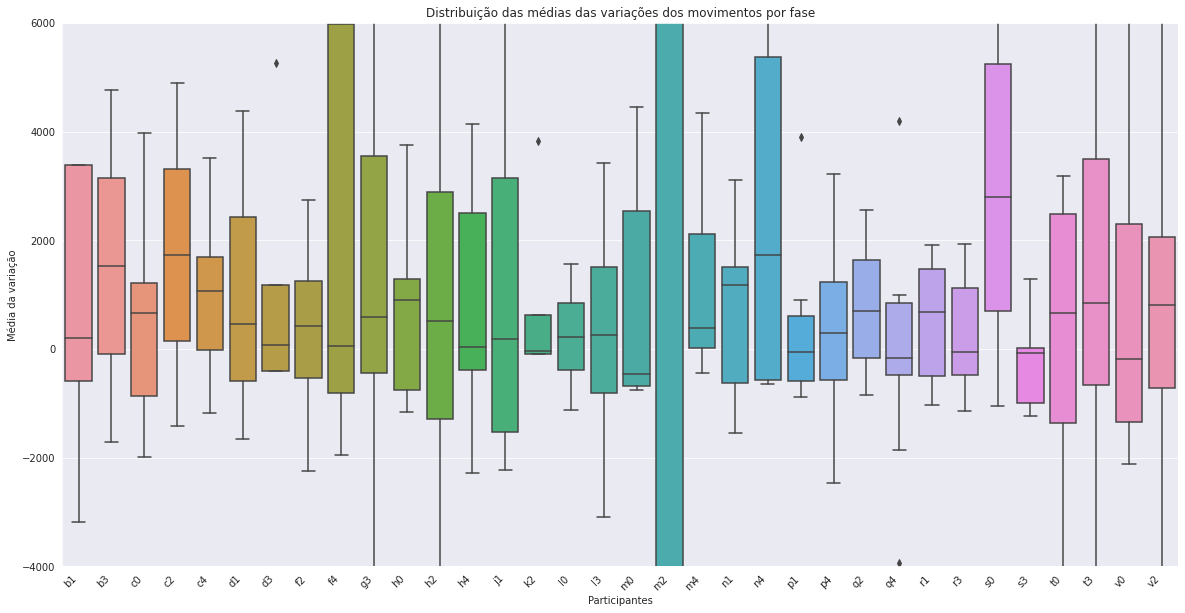

In [128]:
ds = df.groupby(['doc_id', 'casa'])['movedelta'].mean().reset_index()
import seaborn as sns
import matplotlib.pyplot as plt
chart = sns.boxplot(x="doc_id", y="movedelta", data=ds)
chart.set(
    title='Distribuição das médias das variações dos movimentos por fase', ylabel='Média da variação', xlabel='Participantes')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(ylim=(-4000, 6000))
plt.gcf().set_size_inches(20, 10)
# ds

## Média das acelerações do tempo de jogada
Observando as acelerações das médias dos tempos das jogadas, considerando as diversas fases do jogo.


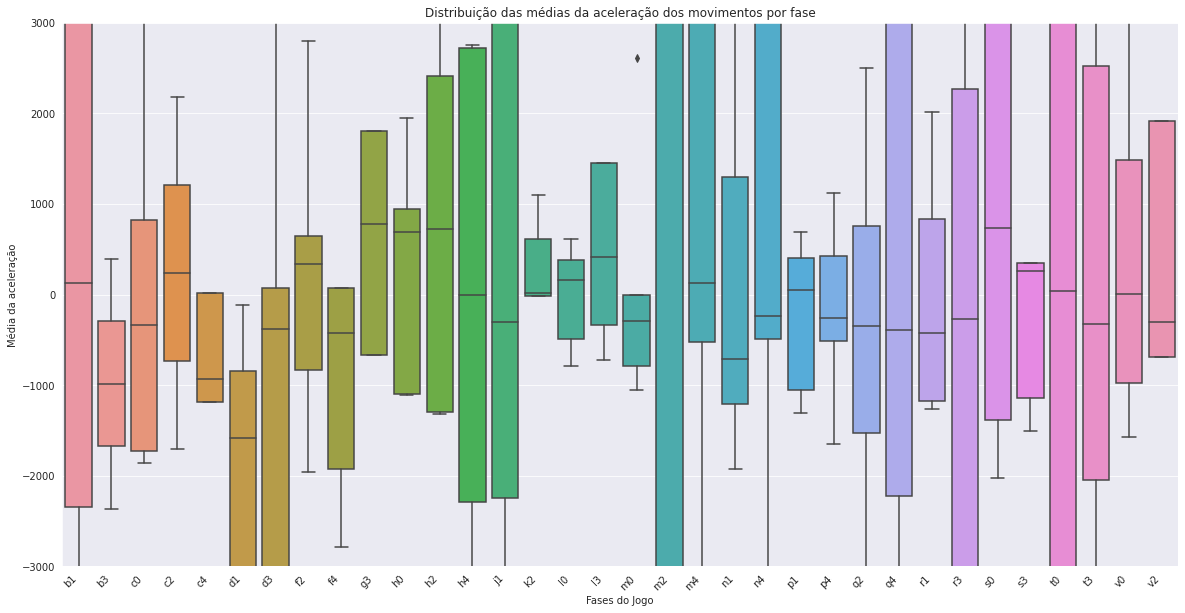

In [129]:
dj = df.groupby(['doc_id', 'casa'])['movejump'].mean().reset_index()
import seaborn as sns
import matplotlib.pyplot as plt
chart = sns.boxplot(x="doc_id", y="movejump", data=dj)
chart.set(
    title='Distribuição das médias da aceleração dos movimentos por fase', ylabel='Média da aceleração', xlabel='Fases do Jogo')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(ylim=(-3000, 3000))
plt.gcf().set_size_inches(20, 10)

## Correlação entre desvio padrão da variação e aceleração

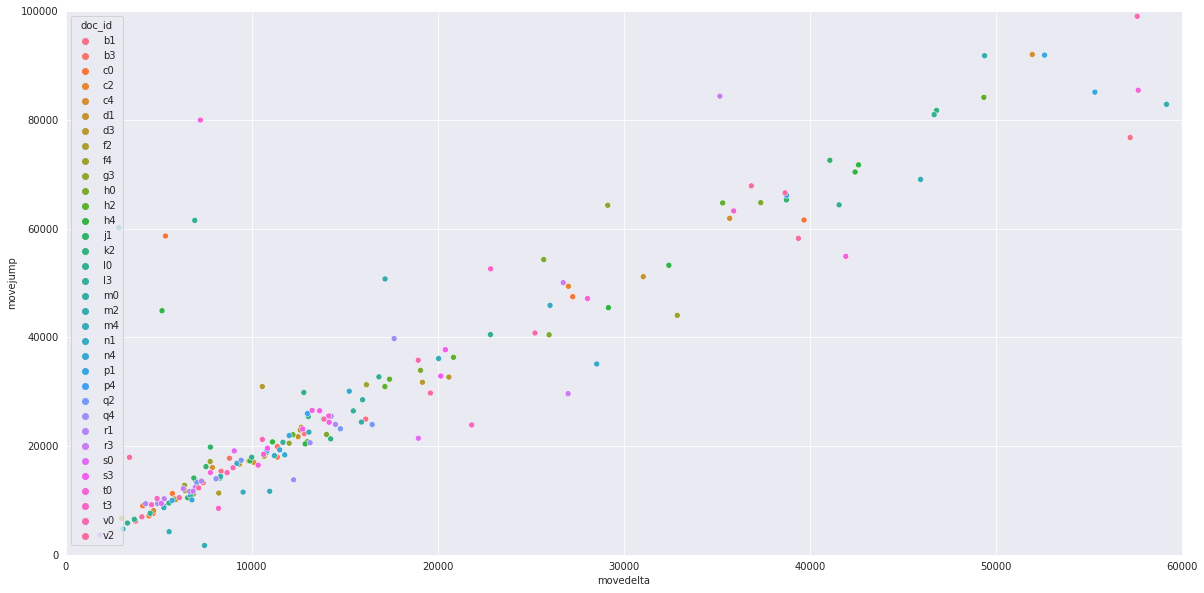

In [130]:
ds = df.groupby(['doc_id', 'casa'])['movedelta'].std().reset_index()
dj = df.groupby(['doc_id', 'casa'])['movejump'].std().reset_index()
dj= dj.join(ds["movedelta"])
sns.scatterplot(data=dj,x="movedelta",y="movejump",hue="doc_id").set(xlim=(0, 60000), ylim=(0, 100000))

plt.gcf().set_size_inches(20, 10)

## Pontuação do erro nas respostas
No jogo existem perguntas sobre o assunto organelas. Esta pontuação mostra o erro acumulado em consecutivas respostas erradas.

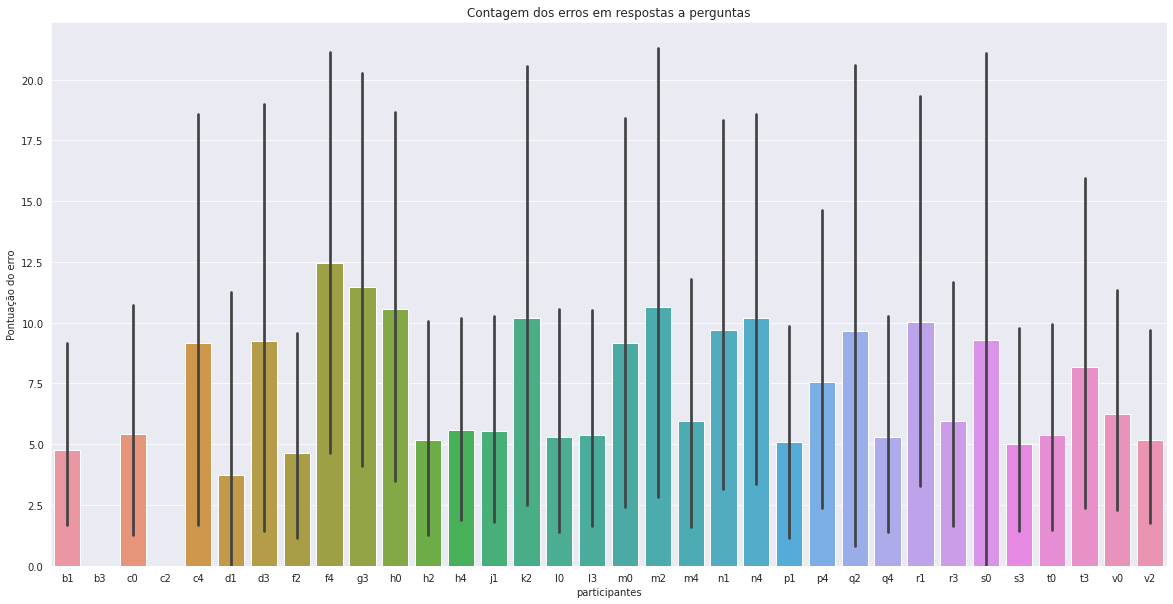

In [131]:
#dj = df[df['move']=='pergunta']
ds = df.groupby(['doc_id','casa', 'carta'])['ponto'].sum().reset_index()
dj = df.groupby(['doc_id', 'casa', 'carta'])['movejump'].std().reset_index()
dj= dj.join(ds["ponto"])

import seaborn as sns
import matplotlib.pyplot as plt
#chart = sns.scatterplot(data=dj,x="ponto",y="movejump",hue="doc_id")
#chart.set(xlim=(0, 45), ylim=(0, 200000))

chart = sns.barplot(x="doc_id", y="ponto", data=dj)
chart.set(
    title='Contagem dos erros em respostas a perguntas', ylabel='Pontuação do erro', xlabel='participantes')
#chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# chart.set(ylim=(0, 25))
plt.gcf().set_size_inches(20, 10)
# dj

## Plotagem da aceleração ao longo do tempo

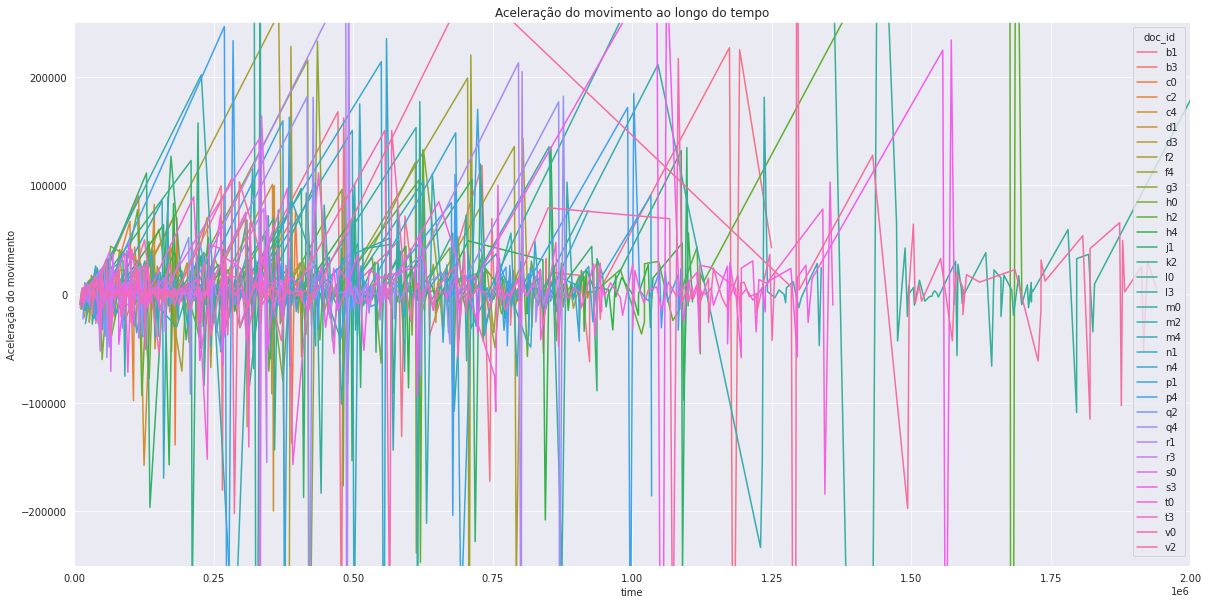

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
# df.assign(sum=df.value.cumsum())
# ds = df.groupby(['doc_id','casa', 'carta'])['movetime'].cumsum().reset_index()
df["time"] = df.groupby(['doc_id'])['movetime'].cumsum() #.apply(lambda x: x.shift()+x)
sns.lineplot(x="time", y="movejump", hue="doc_id", data=df).set(ylim=(-250000, 250000), xlim=(0,2000000),
    title='Aceleração do movimento ao longo do tempo', ylabel='Aceleração do movimento')
plt.gcf().set_size_inches(20, 10)


## Tempo de resolução dos desafios
Algumas fases apresentam desafios que exigem mais tempo para serem resolvidos.

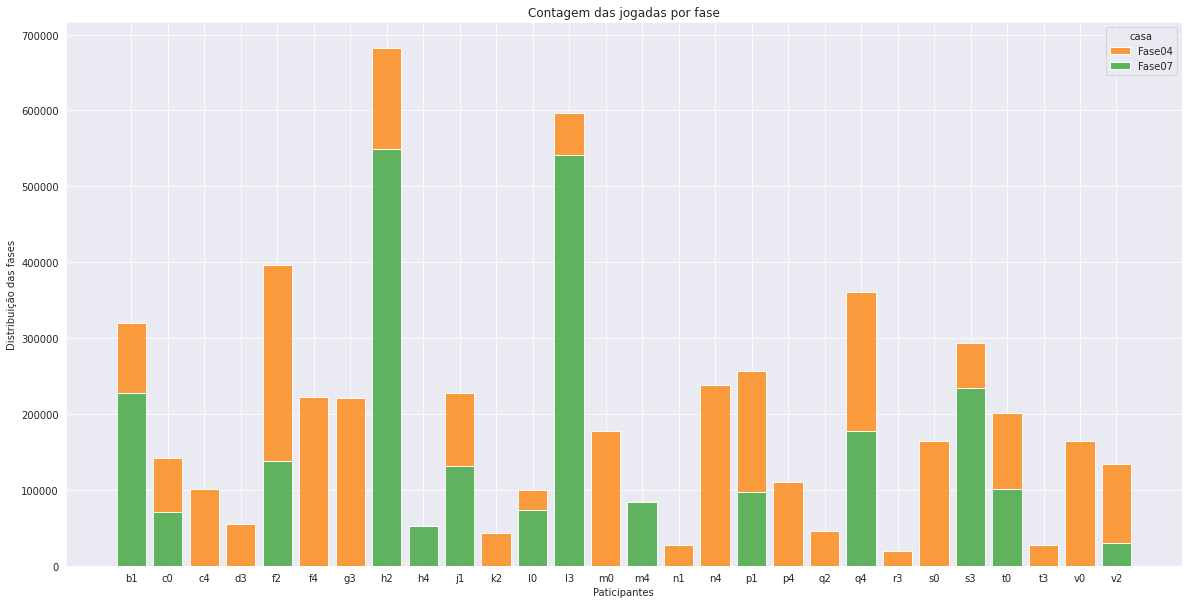

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt
# ds = df.groupby(['doc_id', 'casa', "carta"])['_level'].sum().reset_index()
#ds = df[(df['movetime'] > 50000)&(df['move'] == 'local') ]
ds = df[((df['casa'] == "Fase04")&(df['carta'] == 'parte_0')&(df['move'] == 'local'))|
((df['casa'] == "Fase07")&(df['carta'] == 'parte_4')&(df['move'] == 'local'))
]

'''ds = df.groupby(['doc_id', 'casa'])['_level'].sum().reset_index()
hue_order = [f"Fase{ind:02}" for ind in range(11, 0,-1) if ind not in (8, 10)]
color = "red orange yellow lime green  cyan teal blue indigo magenta purple".split()
da = ds.pivot(['doc_id'], 'casa', '_level') \
      .rename_axis(columns=None).reset_index()
ax = sns.histplot(data = ds, x='doc_id', hue='casa', weights='_level', hue_order=hue_order,
             multiple='stack', palette='Paired_r', shrink=0.8).set(
    title='Contagem das jogadas por fase', ylabel='Distribuição das fases', xlabel="Paticipantes")
plt.gcf().set_size_inches(20, 10)'''
ax = sns.histplot(data = ds, x='doc_id', hue='casa', weights='movetime',
             multiple='stack', palette='Paired_r', shrink=0.8).set(
    title='Contagem das jogadas por fase', ylabel='Distribuição das fases', xlabel="Paticipantes")

plt.gcf().set_size_inches(20, 10)

#ds